# Problem 1

In [331]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("sbaghbidi/human-faces-object-detection")

# print("Path to dataset files:", path)

In [332]:
import pandas as pd
import numpy as np
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm


In [333]:
# Load the CSV file
bbox_data = pd.read_csv('data/faces.csv')

# Get the unique image names - since each image may have multiple bounding boxes, we need to get the unique image names
image_names = bbox_data['image_name'].unique()

# Split the data into training and testing sets
train_images, test_images = train_test_split(image_names, test_size=0.2, random_state=42)

# Create DataFrames for training and testing
train_df = bbox_data[bbox_data['image_name'].isin(train_images)]
test_df = bbox_data[bbox_data['image_name'].isin(test_images)]

print("Training samples:", len(train_df), "Testing samples:", len(test_df))


Training samples: 2686 Testing samples: 664


In [334]:
class FacesDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

        # Get list of unique image names
        self.image_names = self.dataframe['image_name'].unique()

        # Group bounding boxes by image name
        self.groups = self.dataframe.groupby('image_name')

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, image_name)
        image = np.array(Image.open(img_path).convert("RGB"))

        # Get bounding boxes
        records = self.groups.get_group(image_name)
        boxes = records[['x0', 'y0', 'x1', 'y1']].values

        # Select the first bounding box (assuming at least one exists)
        boxes = boxes[0]  # Shape: [4]

        # Apply transformations
        sample = {
            'image': image,
            'bboxes': [boxes],  # Albumentations expects a list of bboxes
            'labels': [0]  # Dummy labels for albumentations lib
        }

        if self.transform:
            sample = self.transform(**sample)

        # Convert to tensors
        image = sample['image']
        boxes = torch.tensor(sample['bboxes'][0])  # Shape: [4]

        return image, boxes

In [335]:
# Random Affine transformation 
transform = A.Compose([
    A.RandomSizedBBoxSafeCrop(width=512, height=512, erosion_rate=0.2, p=1.0),  # Ensure all images are cropped and resized to 512x512
    A.HorizontalFlip(p=0.4),
    A.ColorJitter(p=0.42),
    A.RandomBrightnessContrast(p=0.4),
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)), # because resent model was trained on this normalization
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])) # to take care of bounding boxes


In [336]:

train_dataset = FacesDataset(train_df, image_dir='data/images', transform=transform)
test_dataset = FacesDataset(test_df, image_dir='data/images', transform=transform)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


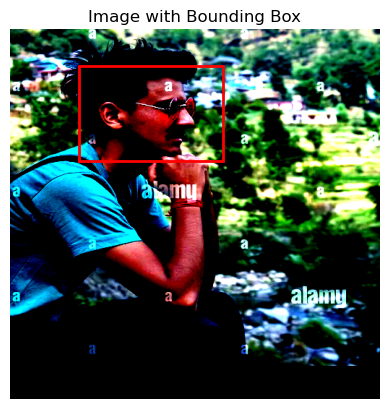

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


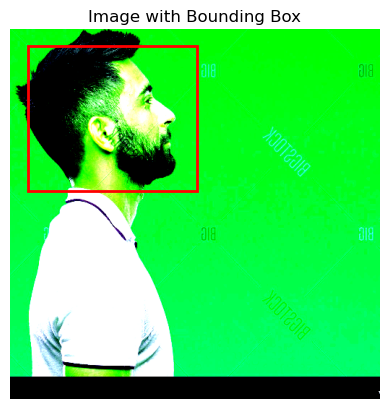

In [337]:
def display_image_with_bboxes(image, bbox, title="Image with Bounding Box"):
    # Convert tensor image to NumPy array
    image = image.permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Plot bounding box
    x0, y0, x1, y1 = bbox
    rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.title(title)
    plt.axis('off')
    plt.show()

# Visualize two samples to ensure random and consistent augmentations
for _ in range(2):
    idx = random.randint(0, len(train_dataset) - 1)
    image, bbox = train_dataset[idx]
    display_image_with_bboxes(image, bbox)

# Section 1.2

I will use the resenet 50 as wegiths as the feature extractor

In [341]:
import torchvision.models as models
import torch.nn as nn
from torchvision.models import ResNet50_Weights
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning) # will get this in juipter notebooks for using the dataloader

# Load pre-trained ResNet-50 model using the updated 'weights' parameter
backbone = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# Freeze backbone weights
for param in backbone.parameters():
    param.requires_grad = False

In [342]:
class ObjectDetectionModel(nn.Module):
    def __init__(self, backbone):
        super(ObjectDetectionModel, self).__init__()
        self.backbone = backbone
        self.backbone.fc = nn.Identity()  # Remove the original classification head
        self.regressor = nn.Linear(2048, 4)  # New regression head for bounding boxes

    def forward(self, x):
        features = self.backbone(x)
        bbox_preds = self.regressor(features)
        return bbox_preds

# Instantiate the model
model = ObjectDetectionModel(backbone)

In [345]:
#num_workers = int((os.cpu_count()-1)/2) # so that we can keep 1 core free at all times minimum

num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=num_workers, pin_memory=True)

# Define loss function and optimizer
criterion = nn.SmoothL1Loss()  # Also known as Huber loss
optimizer = torch.optim.Adam(model.regressor.parameters(), lr=1e-3)

# Determine the device - because I am thinking of either running on my mac or the cloud nodes

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

model.to(device)

# Integrate mixed precision training if using CUDA
use_amp = torch.cuda.is_available()

if use_amp:
    scaler = torch.cuda.amp.GradScaler()

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for images, targets in progress_bar:
        images = images.to(device)
        targets = targets.to(device)  # Shape: [batch_size, 4]

        optimizer.zero_grad()
        if use_amp:
            with torch.cuda.amp.autocast():
                outputs = model(images)  # Shape: [batch_size, 4]
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    epoch_loss /= len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}")



Epoch 1/10: 100%|██████████| 111/111 [01:06<00:00,  1.66batch/s, loss=204]


Epoch [1/10], Average Loss: 215.5807


Epoch 2/10: 100%|██████████| 111/111 [01:04<00:00,  1.72batch/s, loss=195]


Epoch [2/10], Average Loss: 199.8380


Epoch 3/10: 100%|██████████| 111/111 [01:02<00:00,  1.77batch/s, loss=181]


Epoch [3/10], Average Loss: 181.3035


Epoch 4/10: 100%|██████████| 111/111 [01:03<00:00,  1.74batch/s, loss=158]


Epoch [4/10], Average Loss: 168.3665


Epoch 5/10: 100%|██████████| 111/111 [01:04<00:00,  1.72batch/s, loss=68.2]


Epoch [5/10], Average Loss: 155.5508


Epoch 6/10: 100%|██████████| 111/111 [01:03<00:00,  1.76batch/s, loss=145]


Epoch [6/10], Average Loss: 143.4260


Epoch 7/10: 100%|██████████| 111/111 [01:02<00:00,  1.77batch/s, loss=122]


Epoch [7/10], Average Loss: 133.6325


Epoch 8/10: 100%|██████████| 111/111 [01:03<00:00,  1.74batch/s, loss=137]


Epoch [8/10], Average Loss: 123.4352


Epoch 9/10: 100%|██████████| 111/111 [01:03<00:00,  1.74batch/s, loss=131] 


Epoch [9/10], Average Loss: 116.8373


Epoch 10/10: 100%|██████████| 111/111 [01:03<00:00,  1.74batch/s, loss=104] 

Epoch [10/10], Average Loss: 107.8085


In [346]:
def compute_iou(box1, box2):

    # IOU is just intersection over union
    
    xA = torch.max(box1[:, 0], box2[:, 0])
    yA = torch.max(box1[:, 1], box2[:, 1])
    xB = torch.min(box1[:, 2], box2[:, 2])
    yB = torch.min(box1[:, 3], box2[:, 3])

    interWidth = (xB - xA).clamp(min=0)
    interHeight = (yB - yA).clamp(min=0)
    interArea = interWidth * interHeight

    box1Area = (box1[:, 2] - box1[:, 0]).clamp(min=0) * (box1[:, 3] - box1[:, 1]).clamp(min=0)
    box2Area = (box2[:, 2] - box2[:, 0]).clamp(min=0) * (box2[:, 3] - box2[:, 1]).clamp(min=0)

    iou = interArea / (box1Area + box2Area - interArea + 1e-6)
    return iou


In [347]:
model.eval()
with torch.no_grad():
    total_iou = 0
    count = 0
    progress_bar = tqdm(test_loader, desc="Evaluating", unit="batch")
    for images, targets in progress_bar:
        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images)  # Shape: [batch_size, 4]

        # Clamp the outputs to positive values
        outputs = outputs.clamp(min=0)

        ious = compute_iou(outputs, targets)
        total_iou += ious.sum().item()
        count += len(ious)

    mean_iou = total_iou / count
    print(f"Mean IoU on test set: {mean_iou:.4f}")

Evaluating: 100%|██████████| 28/28 [00:14<00:00,  1.92batch/s]

Mean IoU on test set: 0.1144


## Visualizating the images again (with just a trained regressor)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


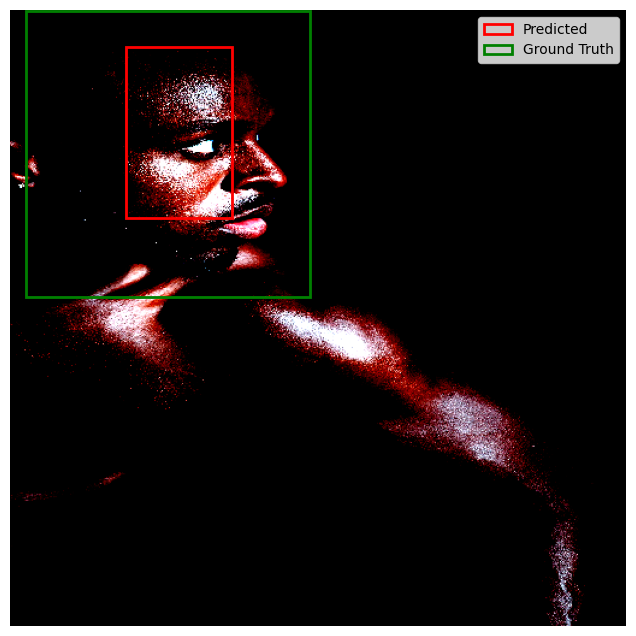

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


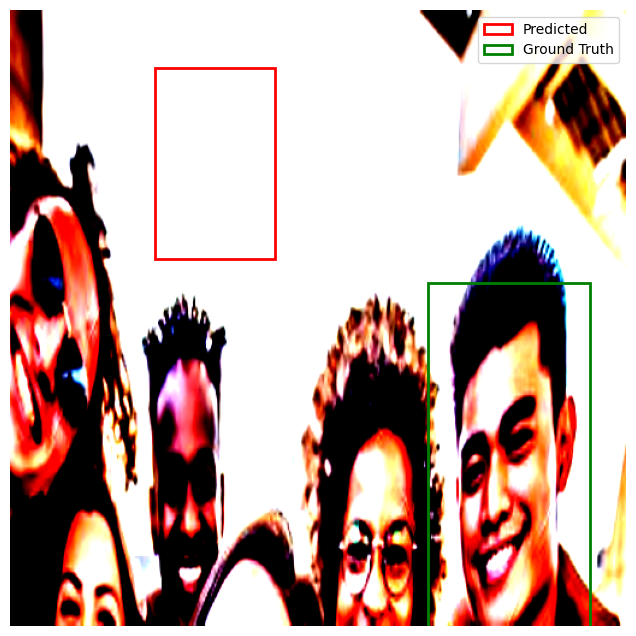

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


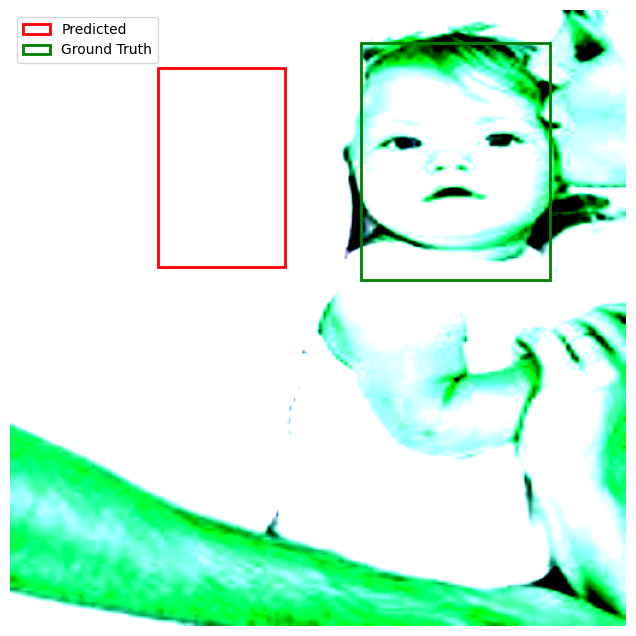

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


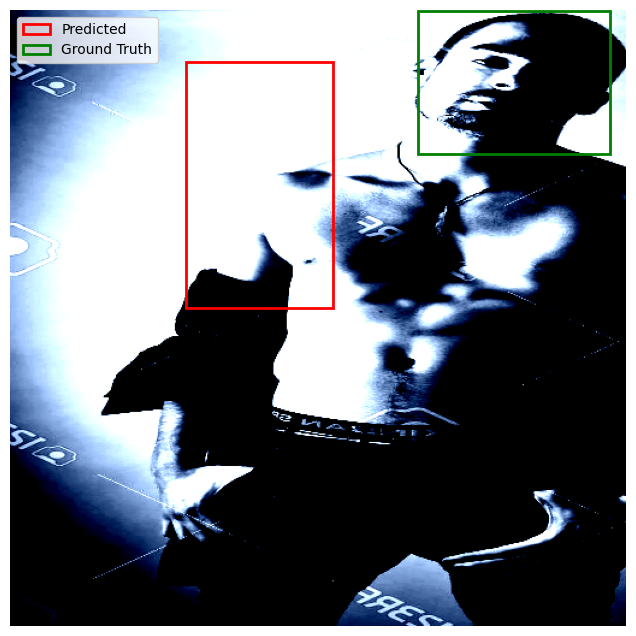

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


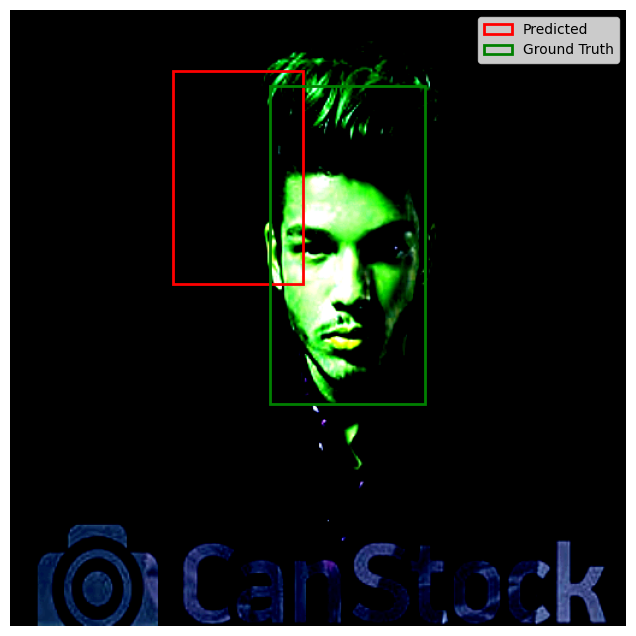

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


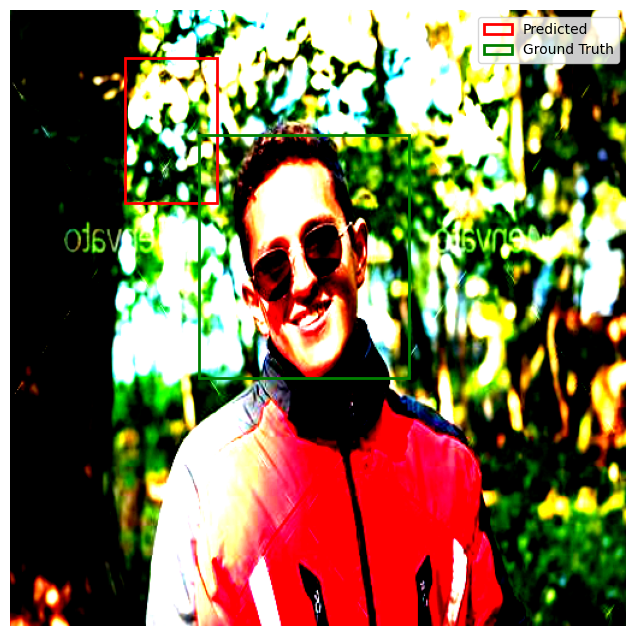

In [348]:
def visualize_predictions(model, dataset, device, num_samples=3):
    model.eval()
    with torch.no_grad():
        for _ in range(num_samples):
            idx = random.randint(0, len(dataset) - 1)
            image, target = dataset[idx]
            image_input = image.unsqueeze(0).to(device)  # Add batch dimension
            output = model(image_input)
            output = output.squeeze(0).cpu()

            # Clamp the output to image dimensions if necessary
            output = output.clamp(min=0)

            # Display the image with predicted and ground truth bounding boxes
            image_np = image.permute(1, 2, 0).cpu().numpy()
            fig, ax = plt.subplots(1, figsize=(8, 8))
            ax.imshow(image_np)

            # Predicted bounding box (red)
            x0, y0, x1, y1 = output
            rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none', label='Predicted')
            ax.add_patch(rect)

            # Ground truth bounding box (green)
            x0_gt, y0_gt, x1_gt, y1_gt = target
            rect_gt = patches.Rectangle((x0_gt, y0_gt), x1_gt - x0_gt, y1_gt - y0_gt, linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth')
            ax.add_patch(rect_gt)

            plt.legend()
            plt.axis('off')
            plt.show()

# Visualize predictions
visualize_predictions(model, test_dataset, device, num_samples=3)
visualize_predictions(model, test_dataset, device, num_samples=3)


# 1.3

## training without freezing the models

i.e is training the convulations too

In [349]:
# Unfreeze all layers in the backbone
for param in backbone.parameters():
    param.requires_grad = True

# Update the optimizer to include all parameters with a lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Lower LR for fine-tuning


In [350]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for images, targets in progress_bar:
        images = images.to(device)
        targets = targets.to(device)  # Shape: [batch_size, 4]

        optimizer.zero_grad()
        if use_amp:
            with torch.cuda.amp.autocast():
                outputs = model(images)  # Shape: [batch_size, 4]
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    epoch_loss /= len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}")


Epoch 1/10: 100%|██████████| 111/111 [02:38<00:00,  1.43s/batch, loss=83]  


Epoch [1/10], Average Loss: 74.7684


Epoch 2/10: 100%|██████████| 111/111 [02:30<00:00,  1.36s/batch, loss=60]  


Epoch [2/10], Average Loss: 69.3405


Epoch 3/10: 100%|██████████| 111/111 [02:33<00:00,  1.38s/batch, loss=66.8]


Epoch [3/10], Average Loss: 66.3507


Epoch 4/10: 100%|██████████| 111/111 [02:39<00:00,  1.44s/batch, loss=46.9]


Epoch [4/10], Average Loss: 65.5938


Epoch 5/10: 100%|██████████| 111/111 [02:41<00:00,  1.45s/batch, loss=46.9]


Epoch [5/10], Average Loss: 63.0259


Epoch 6/10: 100%|██████████| 111/111 [02:35<00:00,  1.40s/batch, loss=53.6]


Epoch [6/10], Average Loss: 62.7555


Epoch 7/10: 100%|██████████| 111/111 [02:37<00:00,  1.41s/batch, loss=47.4]


Epoch [7/10], Average Loss: 60.6764


Epoch 8/10: 100%|██████████| 111/111 [02:39<00:00,  1.44s/batch, loss=37.1]


Epoch [8/10], Average Loss: 59.1738


Epoch 9/10: 100%|██████████| 111/111 [02:31<00:00,  1.36s/batch, loss=66.2]


Epoch [9/10], Average Loss: 57.5623


Epoch 10/10: 100%|██████████| 111/111 [02:36<00:00,  1.41s/batch, loss=64.5]

Epoch [10/10], Average Loss: 56.9597


In [351]:
model.eval()
with torch.no_grad():
    total_iou = 0
    count = 0
    for images, targets in test_loader:
        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images)

        # Clamp the outputs to image size if necessary
        outputs = outputs.clamp(min=0)

        ious = compute_iou(outputs, targets)
        total_iou += ious.sum().item()
        count += len(ious)

    mean_iou = total_iou / count
    print(f"Mean IoU on test set after fine-tuning: {mean_iou:.4f}")


Mean IoU on test set after fine-tuning: 0.4187


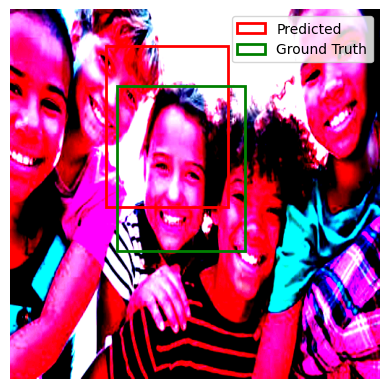

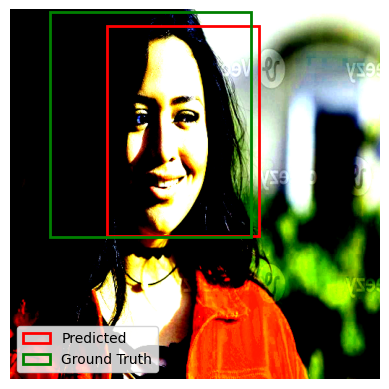

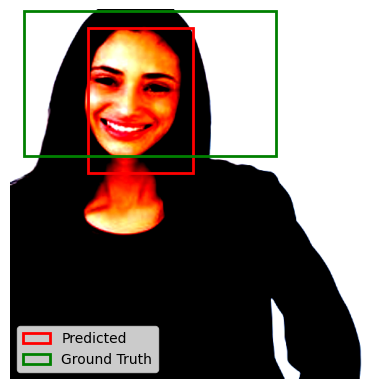

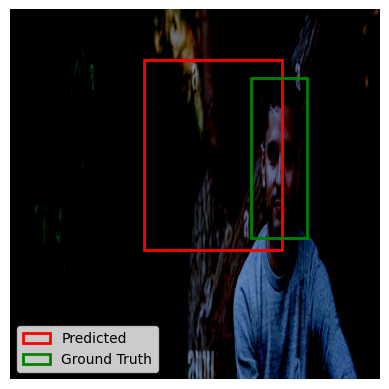

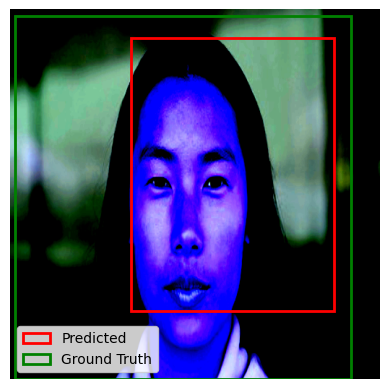

In [352]:
with torch.no_grad():
    for _ in range(5):
        idx = random.randint(0, len(test_dataset) - 1)
        image, target = test_dataset[idx]
        image_input = image.unsqueeze(0).to(device)  # Add batch dimension
        output = model(image_input)
        output = output.squeeze(0).cpu()

        # Clamp the output to image dimensions
        output = output.clamp(min=0)

        # Display the image with predicted and ground truth bounding boxes
        image_np = image.permute(1, 2, 0).cpu().numpy()
        fig, ax = plt.subplots(1)
        ax.imshow(np.clip(image_np, 0, 1))

        # Predicted bounding box (red)
        x0, y0, x1, y1 = output
        rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none', label='Predicted')
        ax.add_patch(rect)

        # Ground truth bounding box (green)
        x0_gt, y0_gt, x1_gt, y1_gt = target
        rect_gt = patches.Rectangle((x0_gt, y0_gt), x1_gt - x0_gt, y1_gt - y0_gt, linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth')
        ax.add_patch(rect_gt)

        plt.legend()
        plt.axis('off')
        plt.show()


## **1.4 Write-Up: Adapting to Multiple Objects in Object Detection**

### **Challenges with Multiple Objects**

The current model is limited in its ability to detect only a single bounding box per image. If an image contains multiple objects (faces), this model will face significant limitations:

- **Limited Output**: Since it is designed to predict just one bounding box, it can potentially miss other objects present in the image.
- **Ambiguity**: When multiple objects are present, the model will struggle to decide which object to prioritize, leading to inconsistent or inaccurate predictions.

### **Proposed Solutions**

To effectively handle multiple objects within an image, the model architecture can be adapted using approaches similar to those employed in **RCNN**, **Faster R-CNN** and **YOLO** as we leanred in class:

- **Faster R-CNN**: This model uses traditional imaging techniques in conjunction with a region proposal network (RPN) to first identify potential objects within an image. The RPN then categorizes each proposed region into **N+1 classes** (where the additional class represents the background). This approach enables the model to detect multiple objects by generating separate bounding boxes for each one. Faster R-CNN is highly accurate and suitable for complex scenes, albeit slightly slower than more modern methods.
  
- **YOLO (You Only Look Once)**: Inspired by Faster R-CNN, YOLO approaches object detection by dividing the image into a grid and predicting bounding boxes and class probabilities for each grid cell. This fully neural approach allows YOLO to perform object detection at significantly faster speeds (and higher accuracies), making it well-suited for real-time applications. YOLO’s approach enables the model to adapt to varying numbers of objects, effectively improving detection accuracy in complex scenes.

Incorporating such methods would allow the model to detect multiple objects, mitigate the ambiguity issue, and increase detection robustness, even when faced with diverse and crowded images.

### **Relevant Literature**

1. **Faster R-CNN**: Ren, S., He, K., Girshick, R., & Sun, J. (2015). *Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks*. [Link](https://arxiv.org/abs/1506.01497)
  
2. **YOLOv3**: Redmon, J., & Farhadi, A. (2018). *YOLOv3: An Incremental Improvement*. [Link](https://arxiv.org/pdf/1804.02767)
  
3. **YOLO**: Redmon, J., Divvala, S., Girshick, R., & Farhadi, A. (2016). *You Only Look Once: Unified, Real-Time Object Detection*. [Link](https://arxiv.org/pdf/1506.02640)
